In [1]:
#
# COMMENTS TO DO
#
#Condensed code based on the code from: https://jmetzen.github.io/2015-11-27/vae.html

%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import time
import glob

from tensorflow.examples.tutorials.mnist import input_data

def plot(samples, w, h, fw, fh, iw=28, ih=28):
    fig = plt.figure(figsize=(fw, fh))
    gs = gridspec.GridSpec(w, h)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(iw, ih), cmap='Greys_r')

    return fig


def encoder(images, num_outputs_h0=8, num_outputs_h1=16, kernel_size=5, stride=2, num_hidden_fc=1024, z_dim=100):
        
    print("Encoder")

    h0 = layers.convolution2d(
        inputs=images,
        num_outputs=num_outputs_h0,
        kernel_size=kernel_size,
        stride=stride,
        activation_fn=tf.nn.relu,
        scope='e_cnn_%d' % (0,)
    )
    
    print("Convolution 1 -> {}".format(h0))

    h1 = layers.convolution2d(
        inputs=h0,
        num_outputs=num_outputs_h1,
        kernel_size=kernel_size,
        stride=stride,
        activation_fn=tf.nn.relu,
        scope='e_cnn_%d' % (1,)
    )
    
    print("Convolution 2 -> {}".format(h1))

    h1_dim = h1.get_shape().as_list()[1]

    h2_flat = tf.reshape(h1, [-1, h1_dim * h1_dim * num_outputs_h1])

    print("Reshape  -> {}".format(h2_flat))
    
    h2_flat =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=num_hidden_fc,
        activation_fn=tf.nn.relu,
        scope='e_d_%d' % (0,)
    )
    
    print("FC 1  -> {}".format(h2_flat))

    z_mean =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=z_dim,
        activation_fn=None,
        scope='e_d_%d' % (1,)
    )
    
    print("Z mean -> {}".format(z_mean))

    z_log_sigma_sq =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=z_dim,
        activation_fn=None,
        scope='e_d_%d' % (2,)
    )

    return z_mean, z_log_sigma_sq 



def decoder(z, num_hidden_fc=1024, h1_reshape_dim=7, kernel_size=5, h1_channels=16, h2_channels = 8, output_channels=1, strides=2, output_dims=784):
    
    print("Decoder")
    
    batch_size = tf.shape(z)[0]  
    
    h0 =layers.fully_connected(
        inputs=z,
        num_outputs=num_hidden_fc,
        activation_fn=tf.nn.relu,
        scope='d_d_%d' % (0,)
    )
    
    print("FC 1  -> {}".format(h0))

    h1 =layers.fully_connected(
        inputs=h0,
        num_outputs=h1_reshape_dim*h1_reshape_dim*h1_channels,
        activation_fn=tf.nn.relu,
        scope='d_d_%d' % (1,)
    )
    
    print("FC 2  -> {}".format(h1))

    h1_reshape = tf.reshape(h1, [-1, h1_reshape_dim, h1_reshape_dim, h1_channels])

    print("Reshape  -> {}".format(h1_reshape))

    wdd2 = tf.get_variable('wd2', shape=(kernel_size, kernel_size, h2_channels, h1_channels), initializer=tf.contrib.layers.xavier_initializer())
    bdd2 = tf.get_variable('bd2', shape=(h2_channels,), initializer=tf.constant_initializer(0))
    
    h2 = tf.nn.conv2d_transpose(h1_reshape, wdd2, output_shape=(batch_size, h1_reshape_dim*2,  h1_reshape_dim*2, h2_channels), strides=(1, strides, strides, 1), padding='SAME')

    h2_out = tf.nn.relu(h2 + bdd2)
    
    h2_out = tf.reshape(h2_out, (batch_size, h1_reshape_dim*2,  h1_reshape_dim*2, h2_channels))
    
    print("DeConv 1  -> {}".format(h2_out))
    
    h2_dim = h2_out.get_shape().as_list()[1]

    wdd3 = tf.get_variable('wd3', shape=(kernel_size, kernel_size, output_channels, h2_channels), initializer=tf.contrib.layers.xavier_initializer())
    bdd3 = tf.get_variable('bd3', shape=(output_channels,), initializer=tf.constant_initializer(0))
 
    h3 = tf.nn.conv2d_transpose(h2_out, wdd3, output_shape=(batch_size, h2_dim*2, h2_dim*2, output_channels), strides=(1, strides, strides, 1), padding='SAME')

    h3_out = tf.nn.sigmoid(h3 + bdd3)
    
    #Workaround to use dinamyc batch size...
    h3_out = tf.reshape(h3_out, (batch_size, h2_dim*2, h2_dim*2, output_channels))

    print("DeConv 2  -> {}".format(h3_out))

    h3_reshape = tf.reshape(h3_out, [-1, output_dims])
    
    print("Reshape  -> {}".format(h3_reshape))

    return h3_reshape
    

mnist = input_data.read_data_sets('DATASETS/MNIST_TF', one_hot=True)

#For reconstructing the same or a different image (denoising)
images = tf.placeholder(tf.float32, shape=(None, 784))

images_28x28x1 = tf.reshape(images, [-1, 28, 28, 1])

images_target = tf.placeholder(tf.float32, shape=(None, 784))

is_training_placeholder = tf.placeholder(tf.bool)
learning_rate_placeholder = tf.placeholder(tf.float32)

z_dim = 100

with tf.variable_scope("encoder") as scope:

    z_mean, z_log_sigma_sq = encoder(images_28x28x1)
    

with tf.variable_scope("reparameterization") as scope:
    
    eps = tf.random_normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0, dtype=tf.float32)

    # z = mu + sigma*epsilon
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    

with tf.variable_scope("decoder") as scope:
        
    x_reconstr_mean = decoder(z)
    
    scope.reuse_variables()

    ##### SAMPLING #######
    
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim])

    x_sample = decoder(z_input)


#reconstr_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_reconstr_mean, labels=images_target), reduction_indices=1)

offset=1e-7
obs_ = tf.clip_by_value(x_reconstr_mean, offset, 1 - offset)

reconstr_loss = -tf.reduce_sum(images_target * tf.log(obs_) + (1-images_target) * tf.log(1 - obs_), 1)

latent_loss = -.5 * tf.reduce_sum(1. + z_log_sigma_sq - tf.pow(z_mean, 2) - tf.exp(z_log_sigma_sq), reduction_indices=1)

cost = tf.reduce_mean(reconstr_loss + latent_loss)

optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder).minimize(cost)

init = tf.global_variables_initializer()

save_path = "MODELS_CVAE_MNIST/CONV_VAE_MNIST.ckpt"

CVAE_SAVER = tf.train.Saver()

Extracting DATASET/MNIST_TF/train-images-idx3-ubyte.gz
Extracting DATASET/MNIST_TF/train-labels-idx1-ubyte.gz
Extracting DATASET/MNIST_TF/t10k-images-idx3-ubyte.gz
Extracting DATASET/MNIST_TF/t10k-labels-idx1-ubyte.gz
Encoder
Convolution 1 -> Tensor("encoder/e_cnn_0/Relu:0", shape=(?, 14, 14, 8), dtype=float32)
Convolution 2 -> Tensor("encoder/e_cnn_1/Relu:0", shape=(?, 7, 7, 16), dtype=float32)
Reshape  -> Tensor("encoder/Reshape:0", shape=(?, 784), dtype=float32)
FC 1  -> Tensor("encoder/e_d_0/Relu:0", shape=(?, 1024), dtype=float32)
Z mean -> Tensor("encoder/e_d_1/BiasAdd:0", shape=(?, 100), dtype=float32)
Decoder
FC 1  -> Tensor("decoder/d_d_0/Relu:0", shape=(?, 1024), dtype=float32)
FC 2  -> Tensor("decoder/d_d_1/Relu:0", shape=(?, 784), dtype=float32)
Reshape  -> Tensor("decoder/Reshape:0", shape=(?, 7, 7, 16), dtype=float32)
DeConv 1  -> Tensor("decoder/Reshape_1:0", shape=(?, 14, 14, 8), dtype=float32)
DeConv 2  -> Tensor("decoder/Reshape_2:0", shape=(?, 28, 28, 1), dtype=float

Model restored in file: MODELS_CVAE_MNIST/CONV_VAE_MNIST.ckpt


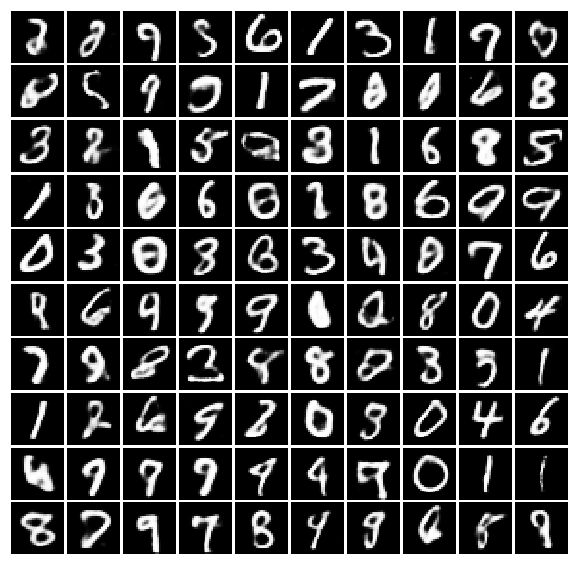

In [2]:
with tf.Session() as sess:
    
    sess.run(init)

    CVAE_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    random_gen = sess.run(x_sample,feed_dict={z_input: np.random.randn(100, z_dim)})
    
    fig=plot(random_gen, 10, 10, 10, 10)
    plt.show()

    
                            

# Creating MNIST subset

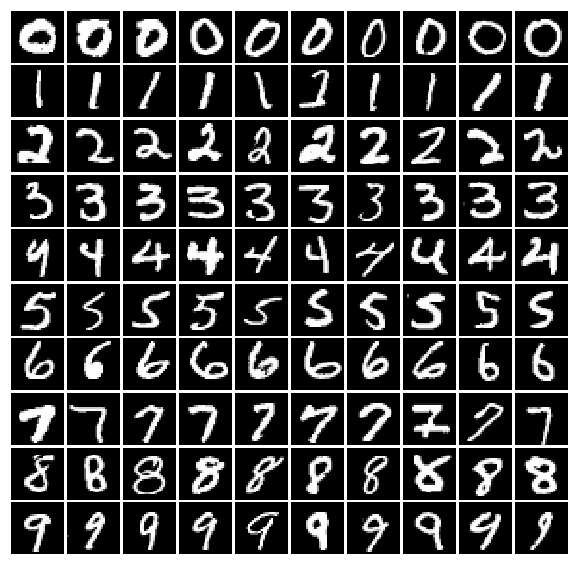

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


In [3]:
labels = 10
subset_size_per_label = 10

for label in range(labels):
    
    indexes = np.where(mnist.train.labels[:,label] == 1)[0]
    np.random.shuffle(indexes)
    
    if label == 0:
        X_mini=mnist.train.images[indexes[:subset_size_per_label]].copy()
        Y_mini=mnist.train.labels[indexes[:subset_size_per_label]].copy()
    else:
        X_mini=np.vstack((X_mini,mnist.train.images[indexes[:subset_size_per_label]].copy()))
        Y_mini=np.vstack((Y_mini,mnist.train.labels[indexes[:subset_size_per_label]].copy()))



fig=plot(X_mini, 10, 10, 10, 10)
plt.show()
print(np.argmax(Y_mini, axis=1))

# Interpolating

In [4]:
from numpy.linalg import norm
import progressbar

def slerp(p0, p1, t):
    omega = np.arccos(np.dot(p0/norm(p0), p1/norm(p1)))
    so = np.sin(omega)
    return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def linear(p0, p1, t):
    return p0 * (1-t) +  p1 * t

def interpolate(sample1, sample2, alphaValues, sess, method="linear"):
    
    x_together = np.vstack((sample1, sample2))
    
    z_samples = sess.run(z, feed_dict={images: x_together})
    
    #fig=plot(z_samples, 1, 2, 10, 10, 10, 10)
    #plt.show()
    
    interpolation_steps = alphaValues.shape[0]
    
    z_interpolations = np.zeros((interpolation_steps, z_dim))
    
    for i, alpha in enumerate(alphaValues):
   
        if method == "slerp":
            z_interpolations[i] = slerp(z_samples[0], z_samples[1], alpha)
        else:
            z_interpolations[i] = linear(z_samples[0], z_samples[1], alpha)
     
    x_interpolated = sess.run(x_sample, feed_dict={z_input: z_interpolations})
    
    #fig=plot(x_interpolated, 1, INTERPOLATION_STEPS, 10, 10)
    #plt.show()
    
    return x_interpolated


labels = 10

INTERPOLATION_STEPS = 10
alphaValues = np.linspace(0, 1, INTERPOLATION_STEPS)

n_gen = labels * subset_size_per_label * (subset_size_per_label - 1) * INTERPOLATION_STEPS

print("Total gen: {}".format(n_gen))

x_pool = np.zeros((n_gen, X_mini.shape[1]))
y_pool = np.zeros((n_gen, Y_mini.shape[1]))

with tf.Session() as sess:
    
    sess.run(init)

    CVAE_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    bar = progressbar.ProgressBar(max_value=n_gen)
    bar.start()
    
    counter = 0
    
    for label in range(labels):
        
        offset = label * subset_size_per_label
        
        for i in range(subset_size_per_label):
            
            samples_ind = list(range(subset_size_per_label))
            samples_ind.remove(i)
            
            x_sample_1 = X_mini[offset + i].copy()
       
            for j in samples_ind:
                
                x_sample_2 = X_mini[offset + j].copy()

                x_output=interpolate(x_sample_1, x_sample_2, alphaValues, sess, method="linear")
                
                x_pool[counter:counter+INTERPOLATION_STEPS] = x_output.copy()
                y_pool[counter:counter+INTERPOLATION_STEPS, label] = 1

                counter+=INTERPOLATION_STEPS

                bar.update(counter)
                
    bar.finish()

  2% (260 of 9000) |                      | Elapsed Time: 0:00:00 ETA:  0:00:00

Total gen: 9000
Model restored in file: MODELS_CVAE_MNIST/CONV_VAE_MNIST.ckpt


100% (9000 of 9000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01


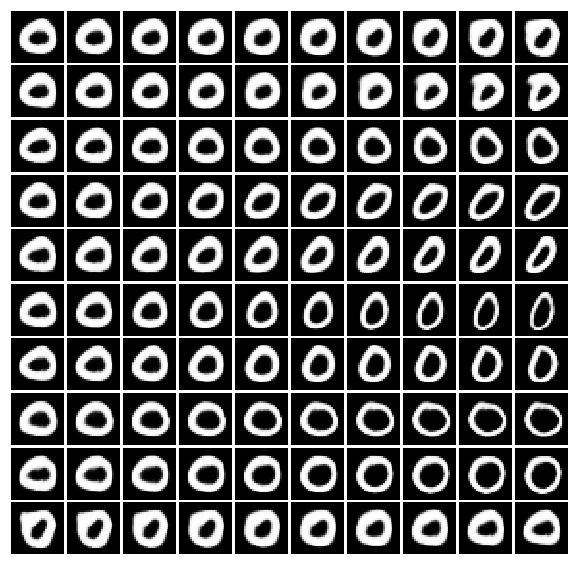

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


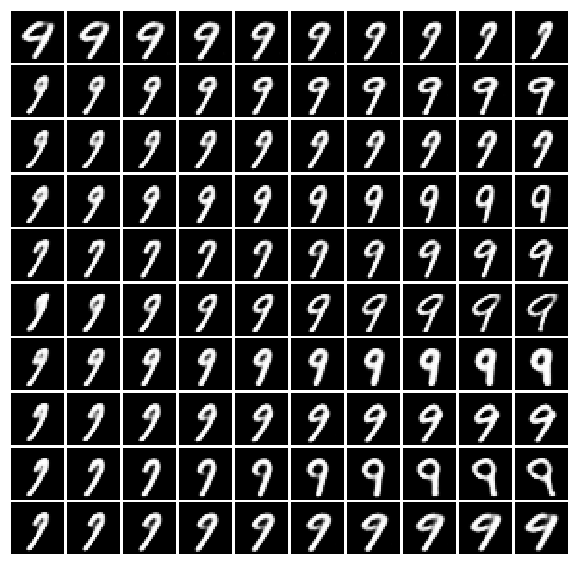

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


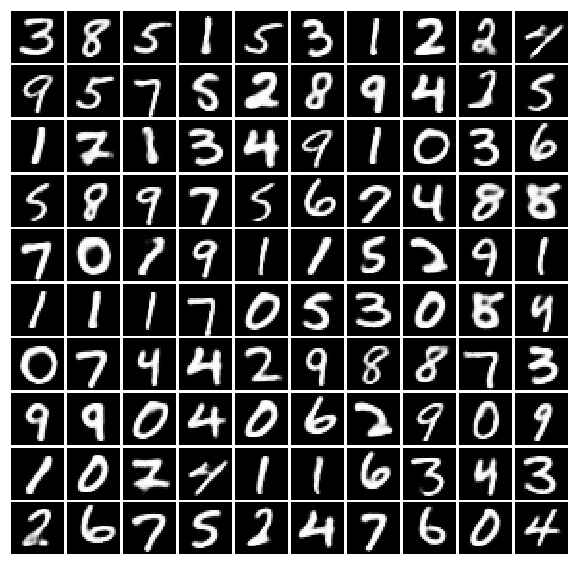

[3 8 5 1 5 3 1 2 2 4 9 5 7 5 2 8 9 4 1 5 1 7 1 3 4 9 1 0 3 6 5 8 9 7 5 6 7
 4 8 8 7 0 1 9 1 1 5 2 4 1 1 1 1 7 0 5 3 0 8 4 0 7 4 4 2 9 8 8 7 3 9 9 0 4
 0 6 2 9 0 9 1 0 7 4 1 1 6 3 4 3 2 6 7 5 1 4 7 6 0 4]


In [5]:
fig=plot(x_pool[:100], 10, 10, 10, 10)
plt.show()
print(np.argmax(y_pool[:100], axis=1))

fig=plot(x_pool[-100:], 10, 10, 10, 10)
plt.show()
print(np.argmax(y_pool[-100:], axis=1))

perm = np.random.permutation(x_pool.shape[0])
x_pool = x_pool[perm]
y_pool = y_pool[perm]

perm = np.random.permutation(x_pool.shape[0])
x_pool = x_pool[perm]
y_pool = y_pool[perm]

fig=plot(x_pool[:100], 10, 10, 10, 10)
plt.show()
print(np.argmax(y_pool[:100], axis=1))

# Storing MINI-MNIST and GEN-MNIST

In [7]:
fx = open("DATASETS/MNIST_ALT/X_MINI_100", "wb")
np.save(fx, X_mini)
fx.close()

fy = open("DATASETS/MNIST_ALT/Y_MINI_100", "wb")
np.save(fy, Y_mini)
fy.close()

fx = open("DATASETS/MNIST_ALT/X_GEN_9K_CVAE", "wb")
np.save(fx, x_pool)
fx.close()

fy = open("DATASETS/MNIST_ALT/Y_GEN_9K_CVAE", "wb")
np.save(fy, y_pool)
fy.close()